In [1]:
import json
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
SEQUENCE_LENGTH = 30

## Data preparation

In [3]:
def load_data(filename):
    """
    Loads one filename
    """
    with open(filename) as json_file:
        return json.load(json_file)

In [4]:
def load_folder(directory='../data/train/'):
    """
    Loads all the raw data from a given directory
    """
    filenames = os.listdir(directory)
    print(f"Loading data from the following files: {filenames}")
    jsons = [load_data(directory + filename) for filename in filenames]
    
    # Merging all dicts into one
    return dict((k,v) for d in jsons for k,v in d.items())

In [5]:
raw_train_data = load_folder(directory='../data/train/')
raw_test_data = load_folder(directory='../data/test/')

print(f"Number of sessions loaded for training: {len(raw_train_data)}")
print(f"Number of sessions loaded for testing: {len(raw_test_data)}")

Loading data from the following files: ['dataset1.json', 'dataset5.json', 'dataset6.json', 'dataset2.json', 'dataset3.json', 'dataset4.json']
Loading data from the following files: ['dataset1.json']
Number of sessions loaded for training: 33
Number of sessions loaded for testing: 5


In [6]:
def preprocess(raw_session_data, sequence_length=10):
    """
    Turns the raw session data into X and Y that can be
    consumed by an ML algorithm
    """
    
    X = []
    Y = []
    
    for (session_id, session_entries) in raw_session_data.items():
        
        xs = [entry['position'] for entry in session_entries]
        ys = [1 if entry['label'] else 0 for entry in session_entries]
        xss = [xs[i:i+sequence_length] for i in range(len(xs) - sequence_length)]
        yss = [[ys[i+sequence_length]] for i in range(len(ys) - sequence_length)]
        X.extend(xss)
        Y.extend(yss)
    
    return np.array(X), np.array(Y)

In [7]:


X_train, Y_train = preprocess(raw_train_data, sequence_length=SEQUENCE_LENGTH)
X_test, Y_test = preprocess(raw_test_data, sequence_length=SEQUENCE_LENGTH)

((X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape))

(((146, 30, 2), (146, 1)), ((10, 30, 2), (10, 1)))

In [8]:
df = pd.DataFrame({
        'x': list(X_train), 
        'y': list(Y_train.squeeze())
     })

In [9]:
df['y'].value_counts()

0    86
1    60
Name: y, dtype: int64

In [10]:
df['y'].value_counts(normalize=True)

0    0.589041
1    0.410959
Name: y, dtype: float64

In [11]:
idx = random.randint(0,len(X_train))
X_train[idx], Y_train[idx]

(array([[0.43734015, 0.2767733 ],
        [0.28005115, 0.29207232],
        [0.1202046 , 0.56467316],
        [0.23657289, 0.67176634],
        [0.61892583, 0.43810848],
        [0.58184143, 0.16968011],
        [0.30818414, 0.18776078],
        [0.15601023, 0.37969402],
        [0.12276215, 0.52851182],
        [0.19820972, 0.60917942],
        [0.36317136, 0.58553547],
        [0.48337596, 0.4255911 ],
        [0.50895141, 0.29485396],
        [0.34782609, 0.19054242],
        [0.17519182, 0.26703755],
        [0.12404092, 0.45062587],
        [0.13682864, 0.51877608],
        [0.16496164, 0.54798331],
        [0.30690537, 0.57579972],
        [0.47570332, 0.47566064],
        [0.50511509, 0.34214186],
        [0.46803069, 0.28789986],
        [0.34782609, 0.27538248],
        [0.22506394, 0.30180807],
        [0.09335038, 0.44645341],
        [0.12148338, 0.58831711],
        [0.30434783, 0.61613352],
        [0.47826087, 0.40611961],
        [0.51534527, 0.26425591],
        [0.373

## Modeling

In [26]:
def get_model():
    """
    Returns the Keras model to train
    """

    return keras.Sequential(
        [   
            layers.Input(shape=(SEQUENCE_LENGTH, 2)),
            layers.LSTM(20),
            # layers.Dropout(0.1),
            layers.Dense(2, activation='softmax')
        ])

In [27]:
model = get_model()

In [28]:
model.compile(
    # loss=keras.losses.BinaryCrossentropy(), 
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1840      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 42        
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________


## Training

In [29]:
history = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_test, Y_test), 
    epochs=100, 
    batch_size=300, 
    verbose=2,
    shuffle=True
)

Epoch 1/100
1/1 - 0s - loss: 0.7066 - accuracy: 0.4110 - val_loss: 0.6752 - val_accuracy: 1.0000
Epoch 2/100
1/1 - 0s - loss: 0.7019 - accuracy: 0.3836 - val_loss: 0.6777 - val_accuracy: 1.0000
Epoch 3/100
1/1 - 0s - loss: 0.6976 - accuracy: 0.3904 - val_loss: 0.6804 - val_accuracy: 0.6000
Epoch 4/100
1/1 - 0s - loss: 0.6936 - accuracy: 0.4315 - val_loss: 0.6834 - val_accuracy: 0.5000
Epoch 5/100
1/1 - 0s - loss: 0.6899 - accuracy: 0.5548 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 6/100
1/1 - 0s - loss: 0.6865 - accuracy: 0.5890 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 7/100
1/1 - 0s - loss: 0.6834 - accuracy: 0.5890 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 8/100
1/1 - 0s - loss: 0.6806 - accuracy: 0.5890 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 9/100
1/1 - 0s - loss: 0.6781 - accuracy: 0.5890 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 10/100
1/1 - 0s - loss: 0.6758 - accuracy: 0.5890 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 11/100
1/1 - 0s - loss:

Epoch 85/100
1/1 - 0s - loss: 0.4967 - accuracy: 0.7671 - val_loss: 0.7703 - val_accuracy: 0.8000
Epoch 86/100
1/1 - 0s - loss: 0.4900 - accuracy: 0.7740 - val_loss: 0.7739 - val_accuracy: 0.8000
Epoch 87/100
1/1 - 0s - loss: 0.4832 - accuracy: 0.7740 - val_loss: 0.7783 - val_accuracy: 0.8000
Epoch 88/100
1/1 - 0s - loss: 0.4765 - accuracy: 0.7740 - val_loss: 0.7833 - val_accuracy: 0.8000
Epoch 89/100
1/1 - 0s - loss: 0.4697 - accuracy: 0.7740 - val_loss: 0.7886 - val_accuracy: 0.8000
Epoch 90/100
1/1 - 0s - loss: 0.4630 - accuracy: 0.7740 - val_loss: 0.7938 - val_accuracy: 0.8000
Epoch 91/100
1/1 - 0s - loss: 0.4563 - accuracy: 0.7808 - val_loss: 0.7993 - val_accuracy: 0.8000
Epoch 92/100
1/1 - 0s - loss: 0.4495 - accuracy: 0.7808 - val_loss: 0.8054 - val_accuracy: 0.8000
Epoch 93/100
1/1 - 0s - loss: 0.4426 - accuracy: 0.7877 - val_loss: 0.8122 - val_accuracy: 0.8000
Epoch 94/100
1/1 - 0s - loss: 0.4358 - accuracy: 0.7877 - val_loss: 0.8191 - val_accuracy: 0.8000
Epoch 95/100
1/1 - 0

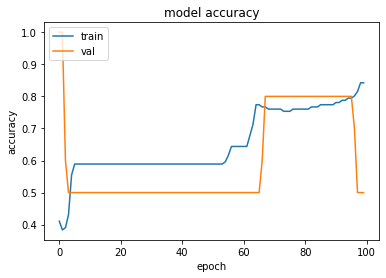

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
model.predict(X_test)

array([[0.7885714 , 0.21142858],
       [0.78926146, 0.21073852],
       [0.68912536, 0.31087464],
       [0.685984  , 0.31401598],
       [0.6845682 , 0.3154318 ],
       [0.7536397 , 0.24636035],
       [0.74604917, 0.2539508 ],
       [0.73722404, 0.26277596],
       [0.7309931 , 0.2690069 ],
       [0.724888  , 0.27511197]], dtype=float32)

In [18]:
model.predict(X_train)

array([[0.83365875, 0.16634119],
       [0.8428246 , 0.15717542],
       [0.83970153, 0.16029845],
       [0.8355447 , 0.16445537],
       [0.8248086 , 0.1751914 ],
       [0.8127077 , 0.18729228],
       [0.7995432 , 0.20045684],
       [0.7930856 , 0.20691445],
       [0.7922435 , 0.20775658],
       [0.8029554 , 0.19704469],
       [0.81855077, 0.18144923],
       [0.86047834, 0.13952167],
       [0.88450366, 0.11549628],
       [0.89046884, 0.10953115],
       [0.88098204, 0.11901799],
       [0.83284366, 0.16715637],
       [0.8922782 , 0.10772176],
       [0.89697546, 0.10302454],
       [0.8971753 , 0.10282467],
       [0.89133245, 0.10866755],
       [0.88297474, 0.1170253 ],
       [0.8733653 , 0.12663475],
       [0.33268094, 0.66731906],
       [0.33423525, 0.66576475],
       [0.33535084, 0.6646491 ],
       [0.33376896, 0.66623104],
       [0.33246046, 0.6675396 ],
       [0.33206332, 0.6679367 ],
       [0.33186   , 0.66813993],
       [0.3317788 , 0.66822124],
       [0.